In [1]:
import os
os.chdir('../')

In [2]:
import torch
import torch.nn as nn
import dataset
import matplotlib.pyplot as plt
import numpy as np

## HuffingtonNews

In [3]:
from arch.news import NetworkNews
ckpt = torch.load('./pretrain/news.pth', map_location='cpu')

classifier = NetworkNews(query_size = 1000, output_size=10, eps=None)
classifier = nn.DataParallel(classifier)
classifier.load_state_dict(ckpt['classifier'])

querier = NetworkNews(query_size = 1000, output_size=1000, eps=0.2)
querier = nn.DataParallel(querier)
querier.load_state_dict(ckpt['querier'])

<All keys matched successfully>

## CUB200

In [3]:
from arch.cub import NetworkCUB, CUBConceptModel
ckpt = torch.load('./pretrain/cub.pth', map_location='cpu')

concept_net = CUBConceptModel.load_from_checkpoint('./pretrain/cub_concept.pth')

classifier = NetworkCUB(query_size=312, output_size=200)
classifier = nn.DataParallel(classifier)
classifier.load_state_dict(ckpt['classifier'])

querier = NetworkCUB(query_size=312, output_size=312)
querier = nn.DataParallel(querier)
querier.load_state_dict(ckpt['querier'])

Lightning automatically upgraded your loaded checkpoint from v1.5.7 to v2.1.4. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint pretrain/cub_concept.pth`


<All keys matched successfully>

## CIFAR10

In [5]:
from arch.cifar10 import DLA
ckpt = torch.load('./pretrain/cifar10.pth', map_location='cpu')

classifier = DLA(num_classes=10)
classifier = nn.DataParallel(classifier)
classifier.load_state_dict(ckpt['classifier'])

querier = DLA(num_classes=49, tau=0.2, resize_conv=True)
querier = nn.DataParallel(querier)
querier.load_state_dict(ckpt['querier'])

<All keys matched successfully>

## MNIST/KMNIST/FashionMNIST

In [3]:
from arch.mnist import ClassifierMNIST, QuerierMNIST
from main_mnist import update_masked_image

### MNIST

In [4]:
# MNIST
ckpt = torch.load('./pretrain/mnist.pth', map_location='cpu')

classifier = ClassifierMNIST()
classifier = nn.DataParallel(classifier)
classifier.load_state_dict(ckpt['classifier'])

querier = QuerierMNIST(num_classes=676, tau=0.2)
querier = nn.DataParallel(querier)
querier.load_state_dict(ckpt['querier'])

<All keys matched successfully>

Raw Image:


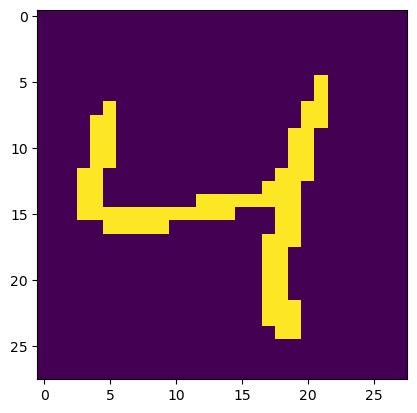

Query 0:


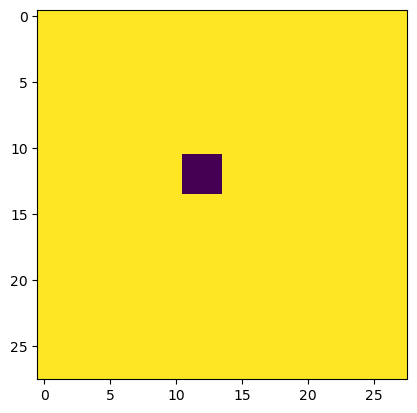

	Prediction: 0
	Query: 348, Patch Centre: (12, 12)
Query 1:


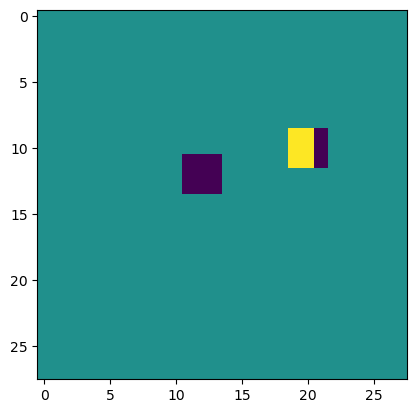

	Prediction: 9
	Query: 300, Patch Centre: (10, 20)
Query 2:


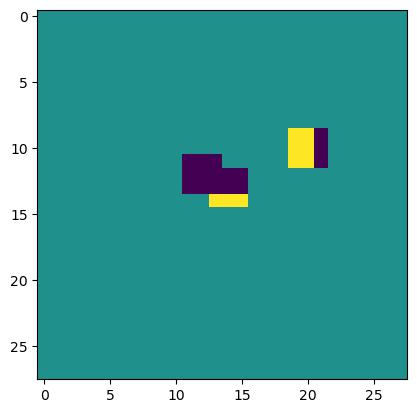

	Prediction: 4
	Query: 378, Patch Centre: (13, 14)
Query 3:


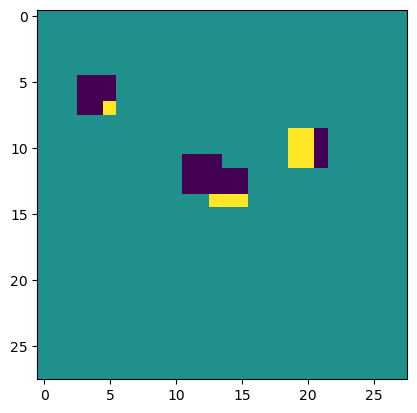

	Prediction: 4
	Query: 172, Patch Centre: (6, 4)
Query 4:


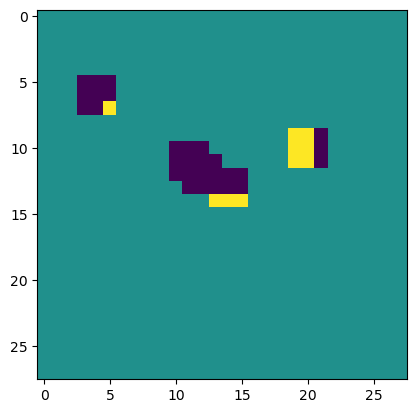

	Prediction: 4
	Query: 319, Patch Centre: (11, 11)
Query 5:


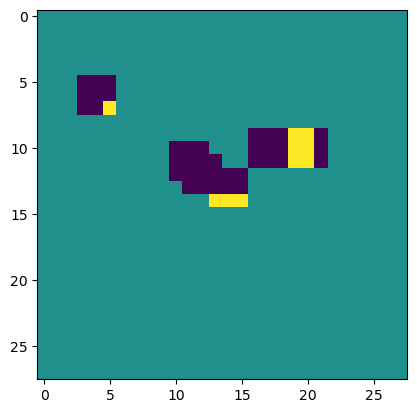

	Prediction: 4
	Query: 297, Patch Centre: (10, 17)
Query 6:


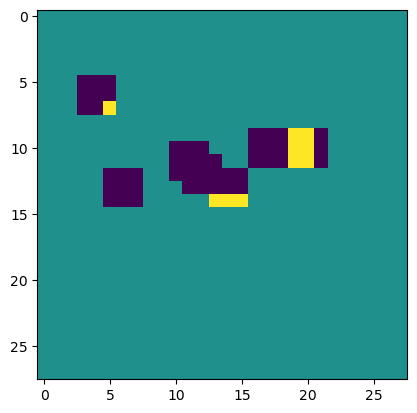

	Prediction: 4
	Query: 370, Patch Centre: (13, 6)
Query 7:


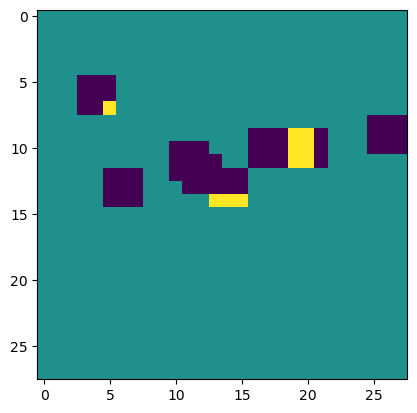

	Prediction: 4
	Query: 278, Patch Centre: (9, 26)
Query 8:


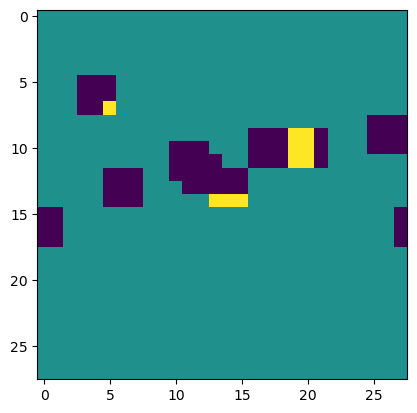

	Prediction: 4
	Query: 448, Patch Centre: (16, 0)
Query 9:


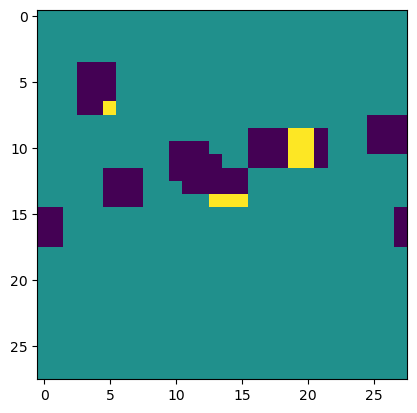

	Prediction: 4
	Query: 144, Patch Centre: (5, 4)
Query 10:


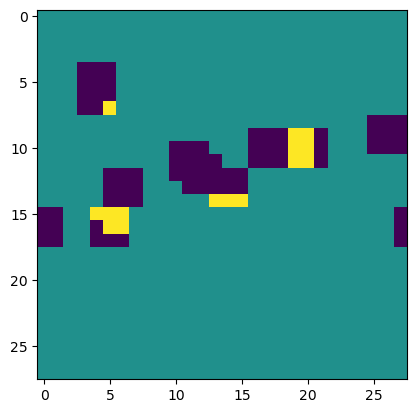

	Prediction: 4
	Query: 453, Patch Centre: (16, 5)
Query 11:


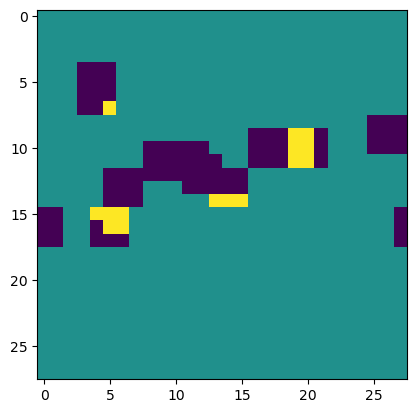

	Prediction: 4
	Query: 317, Patch Centre: (11, 9)
Query 12:


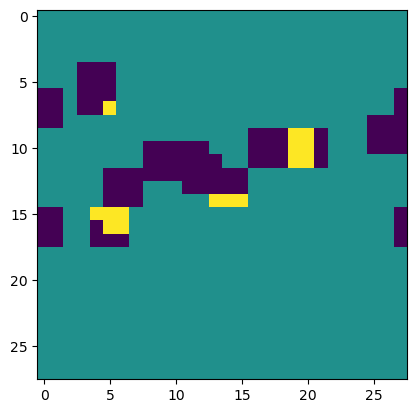

	Prediction: 4
	Query: 196, Patch Centre: (7, 0)
Query 13:


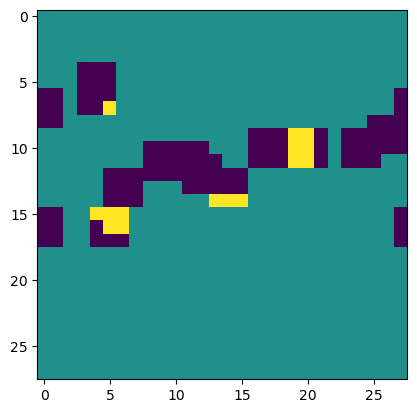

	Prediction: 4
	Query: 304, Patch Centre: (10, 24)
Query 14:


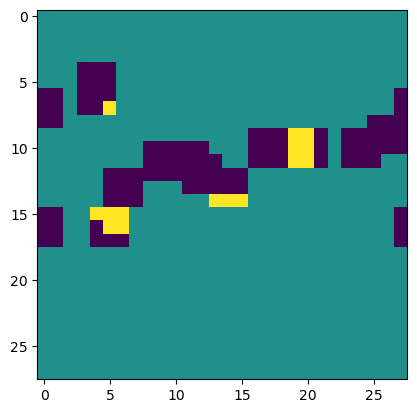

	Prediction: 4
	Query: 318, Patch Centre: (11, 10)
Query 15:


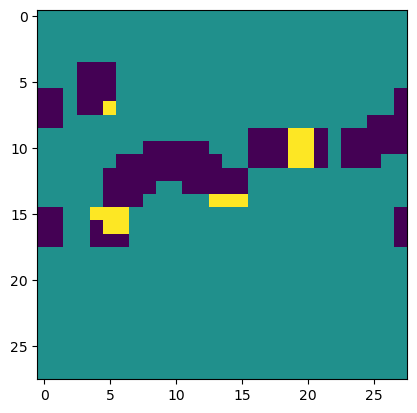

	Prediction: 4
	Query: 343, Patch Centre: (12, 7)
Query 16:


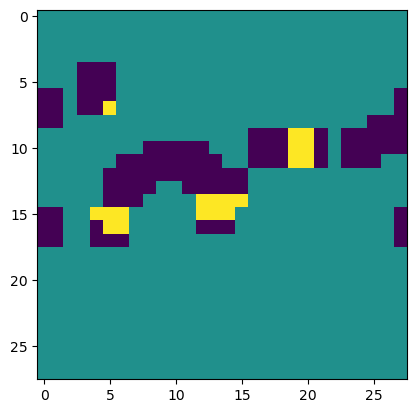

	Prediction: 4
	Query: 433, Patch Centre: (15, 13)
Query 17:


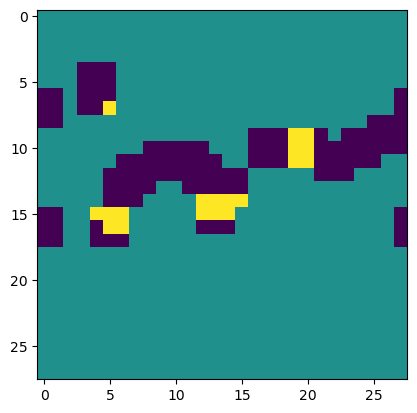

	Prediction: 4
	Query: 330, Patch Centre: (11, 22)
Query 18:


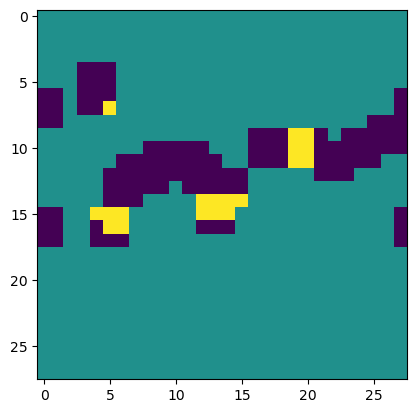

	Prediction: 4
	Query: 344, Patch Centre: (12, 8)
Query 19:


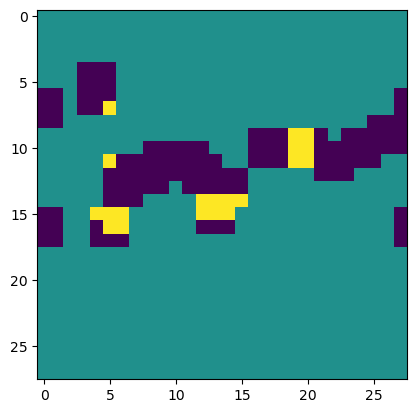

	Prediction: 4
	Query: 342, Patch Centre: (12, 6)
Query 20:


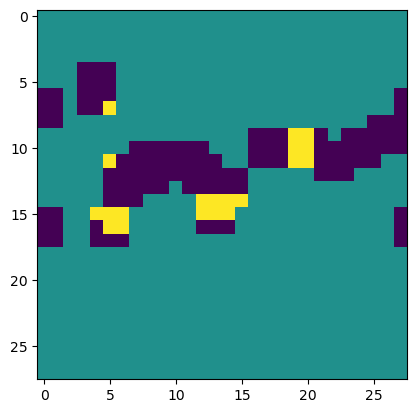

	Prediction: 4
	Query: 316, Patch Centre: (11, 8)


In [75]:
# Data
data_dir = './data/mnist/'
data = dataset.load_mnist(data_dir)

# Perform inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sample_num = 2
img = data[0][sample_num][0]
img = img.unsqueeze(dim=0)
img_2d = img[0][0]
img = img.to(device)

## Constants
N_QUERIES = 676 # 26*26
PATCH_SIZE = 3
THRESHOLD = 0.85
MAX_QUERIES_TEST = 21  # Taken from example training in README.md

# Initialize
N, C, H, W = img.shape
test_input = torch.zeros_like(img).to(device)
mask = torch.zeros(N, N_QUERIES)
logits, queries = [], []

classifier.eval()
querier.eval()

# Querier
for i in range(MAX_QUERIES_TEST):
    with torch.no_grad():
        query_vec = querier(test_input, mask)  # (N, N_QUERIES)
        label_logits = classifier(test_input)  # (N, num_classes)
        
        # Update mask and input image
        mask[np.arange(N), torch.argmax(query_vec, dim=1)] = 1.0
        test_input = update_masked_image(test_input, img, query_vec, patch_size=PATCH_SIZE)  # What does this do?

        queries.append(query_vec)
        logits.append(label_logits)
logits = torch.stack(logits).permute(1, 0, 2)  # (N, MAX_QUERIES_TEST, num_classes)
queries = torch.stack(queries).permute(1, 0, 2) # (N, MAX_QUERIES_TEST, N_QUERIES)

# Print results
print("Raw Image:")
plt.figure()
plt.imshow(img_2d)
plt.show()

# Investigate querying process
for i in range(N):
    queried_img = np.full(img_2d.shape, 0.0)
    for query_num in range(MAX_QUERIES_TEST):
        class_scores = logits[i][query_num]
        pred = torch.argmax(class_scores, dim=0)

        query_scores = queries[i][query_num]
        query = torch.argmax(query_scores, dim=0)

        query_row = query // W
        query_col = query % W
        if (PATCH_SIZE % 2) != 0:  # If odd
            midpoint = PATCH_SIZE // 2
            for j in range(-midpoint, midpoint+1): # rows
                for k in range(-midpoint, midpoint+1):  # columns
                    queried_idx = (query_row+j, query_col+k)
                    queried_img[queried_idx] = img_2d[queried_idx]
                   
        # Visualize
        print(f'Query {query_num}:')
        plt.figure()
        plt.imshow(queried_img)
        plt.show()
        print(f'\tPrediction: {pred}')
        print(f'\tQuery: {query}, Patch Centre: ({query_row}, {query_col})')

### Fashion MNIST

In [8]:
# Fashion MNIST
ckpt = torch.load('./pretrain/fashion_mnist.pth', map_location='cpu')

classifier = ClassifierMNIST()
classifier = nn.DataParallel(classifier)
classifier.load_state_dict(ckpt['classifier'])

querier = QuerierMNIST(num_classes=676, tau=0.2)
querier = nn.DataParallel(querier)
querier.load_state_dict(ckpt['querier'])

<All keys matched successfully>

### KMNIST

In [9]:
# KMNIST
ckpt = torch.load('./pretrain/kmnist.pth', map_location='cpu')

classifier = ClassifierMNIST()
classifier = nn.DataParallel(classifier)
classifier.load_state_dict(ckpt['classifier'])

querier = QuerierMNIST(num_classes=676, tau=0.2)
querier = nn.DataParallel(querier)
querier.load_state_dict(ckpt['querier'])

<All keys matched successfully>

## SymCAT200/300/400

In [10]:
from arch.symcat import NetworkSymCAT

In [11]:
# SymCAT200
ckpt = torch.load('./pretrain/symcat200.pth', map_location='cpu')
net = NetworkSymCAT(K=100, query_size=376, position_embedding_dim=400, output_dim=200, eps=0.2)
net.load_state_dict(ckpt)

<All keys matched successfully>

In [12]:
# SymCAT300
ckpt = torch.load('./pretrain/symcat300.pth', map_location='cpu')
net = NetworkSymCAT(K=100, query_size=376, position_embedding_dim=400, output_dim=300, eps=0.2)
net.load_state_dict(ckpt)

<All keys matched successfully>

In [13]:
# SymCAT400
ckpt = torch.load('./pretrain/symcat400.pth', map_location='cpu')
net = NetworkSymCAT(K=100, query_size=376, position_embedding_dim=400, output_dim=400, eps=0.2)
net.load_state_dict(ckpt)

<All keys matched successfully>